In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download and prepare
data = yf.download('RELIANCE.NS', start='2019-02-01', end='2024-02-01')
data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# RSI function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# All features
data['Returns'] = data['Close'].pct_change()
data['MA_10'] = data['Close'].rolling(10).mean()
data['MA_20'] = data['Close'].rolling(20).mean()
data['MA_50'] = data['Close'].rolling(50).mean()
data['RSI'] = calculate_rsi(data['Close'])
data['Volatility'] = data['Returns'].rolling(30).std()
data['Momentum'] = data['Close'] - data['Close'].shift(10)

print("Data loaded with all features!")
print(data.shape)
print(data.columns.tolist())

[*********************100%***********************]  1 of 1 completed

Data loaded with all features!
(1233, 12)
['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA_10', 'MA_20', 'MA_50', 'RSI', 'Volatility', 'Momentum']


In [2]:
# Create target variable (tomorrow's price)
data['Target'] = data['Close'].shift(-1)

print("Target created!")
print(data[['Close', 'Target']].tail(10))


Target created!
                  Close       Target
Date                                
2024-01-16  1379.762711  1349.511583
2024-01-17  1349.511583  1341.471203
2024-01-18  1341.471203  1365.890429
2024-01-19  1365.890429  1361.671682
2024-01-23  1361.671682  1325.414993
2024-01-24  1325.414993  1333.083178
2024-01-25  1333.083178  1354.474932
2024-01-29  1354.474932  1449.223597
2024-01-30  1449.223597  1393.684781
2024-01-31  1393.684781          NaN


In [3]:
# Remove rows with NaN values
data_clean = data.dropna()

print(f"Original data: {len(data)} rows")
print(f"After removing NaN: {len(data_clean)} rows")
print(f"Rows removed: {len(data) - len(data_clean)}")

# Check what we have
print("\nColumns available:")
print(data_clean.columns.tolist())

Original data: 1233 rows
After removing NaN: 1183 rows
Rows removed: 50

Columns available:
['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA_10', 'MA_20', 'MA_50', 'RSI', 'Volatility', 'Momentum', 'Target']


In [4]:
# Select features
features = ['MA_10', 'MA_20', 'MA_50', 'RSI', 'Volatility', 'Momentum', 'Volume']
X = data_clean[features]
y = data_clean['Target']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFirst 5 rows of X:")
print(X.head())


Features (X) shape: (1183, 7)
Target (y) shape: (1183,)

First 5 rows of X:
                 MA_10       MA_20       MA_50        RSI  Volatility  \
Date                                                                    
2019-04-18  600.801252  604.123043  578.916582  49.299809    0.016018   
2019-04-22  599.956361  604.123047  580.037185  52.462765    0.016016   
2019-04-23  599.380502  603.460471  580.935449  44.216594    0.016063   
2019-04-24  600.016411  603.411559  581.631824  42.493180    0.015966   
2019-04-25  602.693405  604.712262  582.457605  49.078532    0.016087   

             Momentum    Volume  
Date                             
2019-04-18  -7.893151  39286534  
2019-04-22  -8.448910  23607922  
2019-04-23  -5.758585  19807450  
2019-04-24   6.359094  16101112  
2019-04-25  26.769933  30469914  


In [5]:
from sklearn.model_selection import train_test_split

# Calculate 80% point
split_point = int(len(X) * 0.8)

# Split by time (no shuffling!)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"\nTrain period: {X_train.index[0]} to {X_train.index[-1]}")
print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")

Training set: 946 samples
Testing set: 237 samples

Train period: 2019-04-18 00:00:00 to 2023-02-09 00:00:00
Test period: 2023-02-10 00:00:00 to 2024-01-30 00:00:00


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

print("Linear Regression Model Trained!")
print(f"\nTraining Score (R²): {lr_model.score(X_train, y_train):.4f}")
print(f"Testing Score (R²): {lr_model.score(X_test, y_test):.4f}")

Linear Regression Model Trained!

Training Score (R²): 0.9915
Testing Score (R²): 0.9518


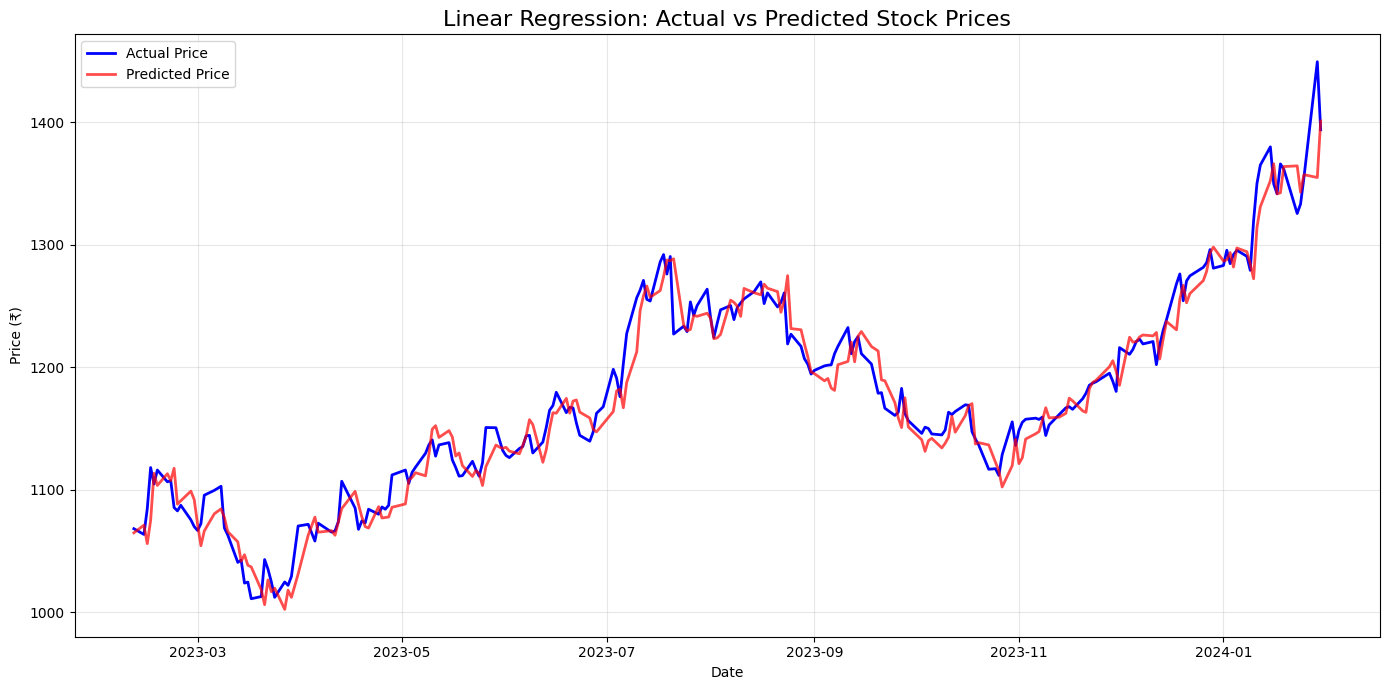

✓ Predictions visualized!


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot actual test prices
plt.plot(y_test.index, y_test.values, label='Actual Price', linewidth=2, color='blue')

# Plot predicted prices
plt.plot(y_test.index, y_pred_test, label='Predicted Price', linewidth=2, color='red', alpha=0.7)

plt.title('Linear Regression: Actual vs Predicted Stock Prices', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/lr_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Predictions visualized!")


In [8]:
print("X_train (features) - first 5 rows:")
print(X_train.head())

print("\n" + "="*60)

print("\ny_train (targets) - first 5 values:")
print(y_train.head())

print("\n" + "="*60)

print("\nExample: April 18, 2019")
print("Input features:")
print(X_train.iloc[0])
print(f"\nTarget (tomorrow's price): {y_train.iloc[0]:.2f}")

X_train (features) - first 5 rows:
                 MA_10       MA_20       MA_50        RSI  Volatility  \
Date                                                                    
2019-04-18  600.801252  604.123043  578.916582  49.299809    0.016018   
2019-04-22  599.956361  604.123047  580.037185  52.462765    0.016016   
2019-04-23  599.380502  603.460471  580.935449  44.216594    0.016063   
2019-04-24  600.016411  603.411559  581.631824  42.493180    0.015966   
2019-04-25  602.693405  604.712262  582.457605  49.078532    0.016087   

             Momentum    Volume  
Date                             
2019-04-18  -7.893151  39286534  
2019-04-22  -8.448910  23607922  
2019-04-23  -5.758585  19807450  
2019-04-24   6.359094  16101112  
2019-04-25  26.769933  30469914  


y_train (targets) - first 5 values:
Date
2019-04-18    604.770075
2019-04-22    599.433931
2019-04-23    609.350381
2019-04-24    617.710427
2019-04-25    611.440327
Name: Target, dtype: float64


Example: April 1

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Create and train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred_test = rf_model.predict(X_test)

# Scores
rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)

print("Random Forest Model Trained!")
print(f"\nTraining Score (R²): {rf_train_score:.4f}")
print(f"Testing Score (R²): {rf_test_score:.4f}")

print("\n" + "="*50)
print("MODEL COMPARISON:")
print("="*50)
print(f"Linear Regression Test Score: 0.9518")
print(f"Random Forest Test Score:      {rf_test_score:.4f}")

Random Forest Model Trained!

Training Score (R²): 0.9989
Testing Score (R²): 0.6442

MODEL COMPARISON:
Linear Regression Test Score: 0.9518
Random Forest Test Score:      0.6442


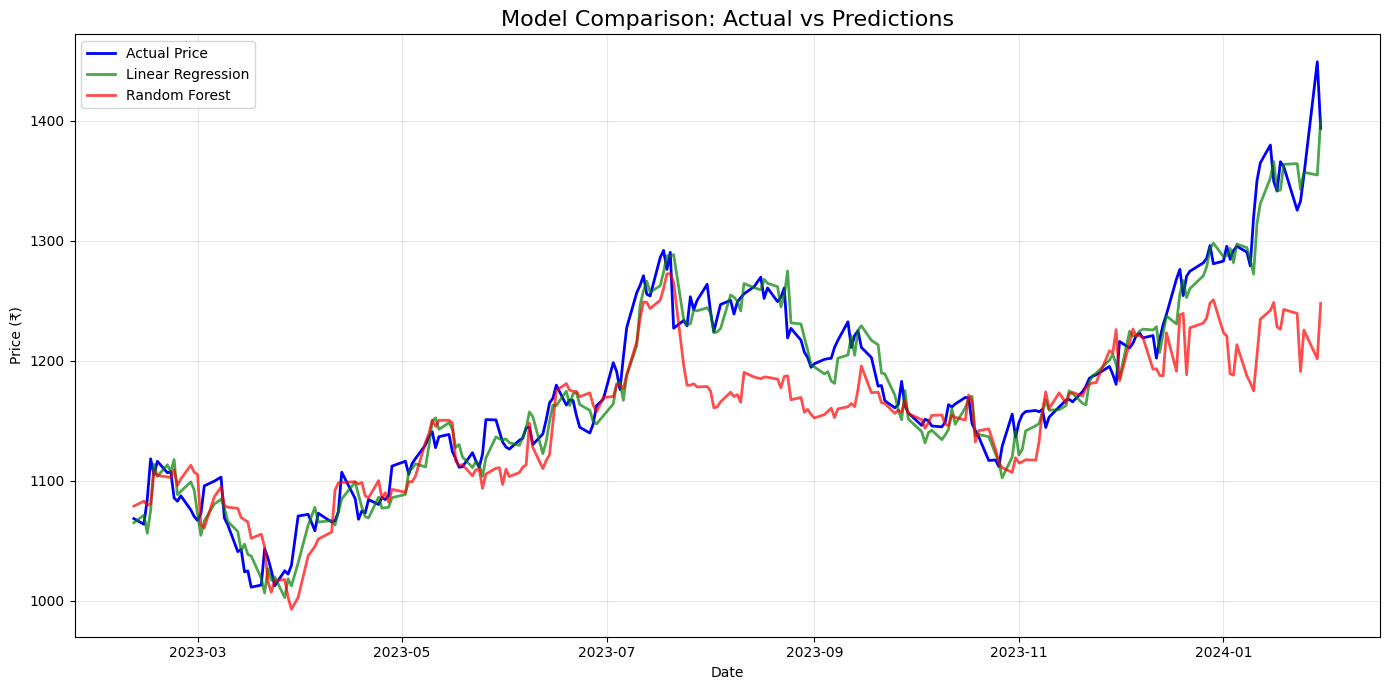

✓ Model comparison visualized!


In [10]:
plt.figure(figsize=(14, 7))

# Actual prices
plt.plot(y_test.index, y_test.values, label='Actual Price', linewidth=2, color='blue')

# Linear Regression predictions
plt.plot(y_test.index, y_pred_test, label='Linear Regression', linewidth=2, color='green', alpha=0.7)

# Random Forest predictions
plt.plot(y_test.index, rf_pred_test, label='Random Forest', linewidth=2, color='red', alpha=0.7)

plt.title('Model Comparison: Actual vs Predictions', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model comparison visualized!")